<center><h1>M1 MMAS - Optimisation</h1><h2>TP2 : descente de gradient par rebroussement d'Armijo</h2></center>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
params = {'tex.usetex': True}

<h2>I - Application à un problème de classification</h2>

In [2]:
# Paramètres pour générer les données du problème.
t = 2*np.pi*np.random.rand()
u = np.array([np.cos(t), np.sin(t)])
#

On considère donnée une famille de couples $((x_i,y_i))_{0\leq i\leq M-1}$ où pour tout $i$, $x_i$ est un point du plan $\mathbb{R}^2$ et $y_i\in\{-1,1\}$ défini l'appartenance de $x_i$ à une des deux classes représentées par les nombres $-1$ et $1$.

Les couples $((x_i,y_i))_{0\leq i\leq M-1}$ sont une réalisation d'un échantillon de taille $M$ de la variable aléatoire $(X,Y)$ à valeurs dans $\mathbb{R}^2\times\{-1,1\}$, c'est-à-dire une réalisation de $M$ variables aléatoires indépendantes $(X_i,Y_i)$ de même loi que le couple $(X,Y)$.

Une réalisation de la variable $(X,Y)$ est donnée par la fonction $\mbox{genererCouple}$ suivante :

In [3]:
def genererCouple():
    # renvoie une réalisation de la variable aléatoire (X,Y)
    if np.random.rand() < 0.5:
        x, y = 2.*np.random.randn(2) + 3*u, -1 # bleu
    else:
        x, y = 2.*np.random.randn(2) - 3*u, 1 # rouge
    return [x, y]

La case suivante génère les données fixées du problème $((x_i,y_i))_{0\leq i\leq M-1}$ et les affiches graphiquement. La population de type "-1" (c'est-à-dire les $x_i$ tels que $y_i=-1$) est affichée en bleu et celle de type "1" en rouge. Les $x_i$ sont stockés dans un vecteur $\mbox{xv}$ et les $y_i$ dans un vecteur $\mbox{yv}$.

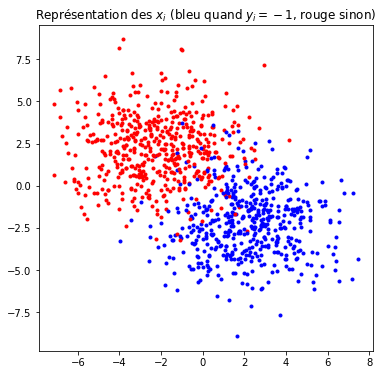

In [4]:
M = 1000
xi_list, yi_list = np.zeros((M, 2)), np.zeros(M)
for i in range(M):
    xi_list[i, :], yi_list[i] = genererCouple() # on stocke les données ((x_i, y_i))_i

# affichage
plt.figure(figsize = (6, 6))
for i in range(M):
    if yi_list[i] == 1: # si x_i est de type 1 alors on affiche un point rouge
        plt.plot(xi_list[i, 0], xi_list[i, 1], linestyle = "none", marker = '.', color = "red")
    else:
        plt.plot(xi_list[i, 0], xi_list[i, 1], linestyle = "none", marker = '.', color = "blue")
plt.title(r"Représentation des $x_i$ (bleu quand $y_i=-1$, rouge sinon)")
plt.axis("tight")
plt.show()

L'objectif de ce TP est, à partir des données d'entraînement ci-dessus $((x_i,y_i))_{0\leq i\leq M-1}$, d'apprendre à prédire, sachant uniquement une nouvelle valeur $x\in\mathbb{R}^2$ de $X$, la valeur du $y$ associé (c'est-à-dire la couleur du point $x$).

Pour cela on va déterminer la meilleur droite passant par $(0,0)$ qui sépare les deux populations (rouge et bleu) des données.

Une droite qui passe par $(0,0)$ a pour équation $f(x) = 0$ où $f : x\in\mathbb{R}^2 \mapsto a_0 x_0 + a_1 x_1$ avec $a = (a_0, a_1)\in\mathbb{R}^2$ un vecteur normal de la droite.

L'idée est donc de trouver la meilleure orientation (paramétrée par $a\in\mathbb{R}^2$) des lignes de niveau de $f$ de sorte qu'un $x$ (généré suivant la loi de $X$) qui se situerait dans le demi-plan où $f$ prend des valeurs négatives, respectivement positives, serait associé à la prédiction $-1$ (couleur bleu), respectivement $1$ (couleur rouge), pour $y$.

Pour déterminer cette meilleure orientation $a\in\mathbb{R}^2$, nous allons chercher à résoudre le problème d'optimisation suivant : 
$$
    \min_{a\in\mathbb{R}^2} \ F(a), \quad \mbox{ où } F:a\in\mathbb{R}^2\mapsto \lambda \|a\|_2^2 + \frac1M \sum_{i=0}^{M-1} \log(1 + e^{-y_i (a_0 x_{i,0} + a_1 x_{i,1})}),
$$
où $\lambda > 0$ est un paramètre fixé et les $x_i = (x_{i,0}, x_{i,1})\in\mathbb{R}^2$ et $y_i\in\{-1,1\}$ sont les données du problème. Ici $\log$ représente le logarithme népérien.

<h3>Résolution numérique du problème d'optimisation</h3>

<b>1) Observer et comprendre la fonction $\mbox{F}$ suivante prenant en argument $\mbox{a}$ et représentant la fonction objectif. Le paramètre $\lambda$ est fixé à $0.05$.

In [5]:
λ = 0.05
def F(a):
    # implémentation vectorialisée du calcul des quantités <xi, a> pour i \in {0,...,M-1}
    y_a = np.dot(xi_list, a)

    L = np.log(1 + np.exp(-yi_list*y_a))
    return λ*np.dot(a, a) + np.sum(L)/M

<b>2) Calculer le gradient et la hessienne de $F$ en $a\in\mathbb{R}^2$. Montrer que $F$ admet un unique minimum global sur $\mathbb{R}^2$.</b>

On a pour tout $a\in\mathbb R^2$, $\nabla F(a) = 2\lambda a + \frac1M\sum_{i=0}^{M-1} f'(y_i\langle x_i, a \rangle) y_i x_i$, où $f:t\in\mathbb{R}\mapsto \log(1+e^{-t})$ et pour tout $t\in\mathbb{R}$, $f'(t) = -\frac{e^{-t}}{1+e^{-t}}$.

Puis pour $a\in\mathbb{R}^2$, $\nabla^2 F(a) = 2\lambda I_2 + \frac1M\sum_{i=0}^{M-1} f''(y_i\langle x_i, a \rangle) x_i x_i^T$. On vérifie aisément que $f'' \geq 0$. De plus pour tout $i$, $x_i x_i^T$ est une matrice symétrique positive puisque pour tout $h\in\mathbb{R}^2$, $h^T x_ix_i^T h = \langle x_i, h \rangle ^2 \geq 0$. Par conséquent, pour tout $h \in\mathbb{R}^2$, et tout $a\in\mathbb{R}^2$, $h^T\nabla^2 F(a) h \geq h^T \left( 2\lambda I_2 \right) h = 2 \lambda \|h\|_2^2$, et donc $\nabla^2 F(a)$ est une matrice définie positive. La fonction $F$ est donc strictement convexe sur $\mathbb{R}^2$.

On sait que le problème $\inf_{\mathbb{R}}^2 F$ est bien posé, par conséquent $F$ admet bien un unique minimum global sur $\mathbb{R}^2$.

Note : pour les détails des calculs (gradient, hessienne) et le caractère bien posé du problème, voir la correction de l'exercice 2 de l'interro 1.

<b>3) Ecrire en Python une fonction $\mbox{gradF}$ prenant en argument $a\in\mathbb{R}^2$ et renvoyant $\nabla F(a)$.</b>

In [6]:
def gradF(a):
    # implementation vectorialisée du calcul du gradient de F
    y_a = np.dot(xi_list, a)
    A = np.exp(-y_a*yi_list) # vecteur de taille M dont les coefficients sont les e^(-y_i <x_i, α>)
    B = -yi_list*A/(1 + A) # vecteur de taille M dont les coefficients sont les -y_i f'(y_i <x_i, α>)
    return 1/M*np.array([np.dot(B, xi_list[:, 0]), np.dot(B, xi_list[:, 1])]) + 2*λ*np.array(a)

In [7]:
# Valider cette case pour vérifier que votre implémentation du gradient de F est correcte
a = np.random.rand(2)
epsilon = 1e-8
print("Cette quantité doit être de l\'ordre de 1e-8 : ", np.linalg.norm(gradF(a) - np.array([(F(a + epsilon*np.array([1,0])) - F(a))/(epsilon), (F(a + epsilon*np.array([0,1])) - F(a))/(epsilon)])))

Cette quantité doit être de l'ordre de 1e-8 :  2.1885359559747984e-08


<b>4) Ecrire en Python une fonction $\mbox{descente_gradient_rebroussement}$ prenant en argument la fonction objectif $f$, son gradient $\mbox{gradf}$, $\mbox{x0}$ (un point de départ), $\alpha$ et $\beta$ (pour la méthode du rebroussement d'Armijo), $\mbox{epsilon}$ (une tolérance), et $\mbox{Niter}$ (un nombre d'itérations maximum); implémentant l'algorithme de la descente de gradient par rebroussement d'Armijo. La fonction renverra la valeur du dernier itéré ainsi que la liste des itérés successifs. On fera attention à évaluer les fonctions $f$ et $\mbox{gradf}$ le moins de fois possible.

On pourra éventuellement implémenter à part une fonction codant la méthode du calcul d'un pas de descente par rebroussement d'Armijo.</b>

In [8]:
def rebroussement_armijo(f, x, gradfx, d, α, β):
    fx = f(x)
    γ = np.dot(gradfx, d)
    t = 1
    while f(x + t*d) > fx + α*t*γ:
        t = β*t
    return t

def descente_gradient_rebroussement(f, gradf, x0, α, β, ε = 1e-4, Niter = 1000):
    x, x_list = x0, [x0]
    d = -gradf(x)
    k = 0
    while np.linalg.norm(d) > ϵ and k < Niter:
        t = rebroussement_armijo(f, x, -d, d, α, β)
        x = x + t*d
        d = -gradF(x)
        x_list.append(x)
        k += 1
    return x, x_list

<b>5) Illustrer la converge de l'algorithme en utilisant la fonction $\mbox{plt.semilogy}$. (Indication : on utilisera d'abord l'algorithme avec une tolérance faible, par exemple $10^{-8}$, et on utilisera l'approximée obtenu comme limite de référence).</b>

In [9]:
a0 = np.array([1, -1.2])
# a_star est utilisé dans l'illustration de la convergence ci-dessous comme représentant le minimum global
a_star, a_list = descente_gradient_rebroussement(F, gradF, a0, 0.1, 0.7, 1e-10)
a_approx, a_list = descente_gradient_rebroussement(F, gradF, a0, 0.1, 0.7, 1e-6)

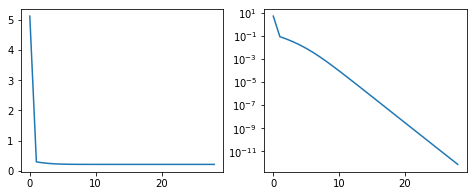

In [10]:
plt.figure(figsize = (8, 3))
plt.subplot(121)
plt.plot(range(len(a_list)), [F(a) for a in a_list])
plt.subplot(122)
# Si on traçait abs(F(a) - F(a_approx)), on aurait a = a_approx pour le dernier élément de a_list et donc
# log(abs(F(a) - F(a_approx))) = -oo et un comportement faussé pour les derniers éléments de a_list.
# En prenant une valeur de a approchant le minimum global avec une bien meilleure tolérante que celle générant la 
# liste utilisée dans le plot, on évite ce soucis.
plt.semilogy(range(len(a_list)),[abs(F(a) - F(a_star)) for a in a_list])
plt.show()

<b>6) De quel type de convergence s'agit-il ? Justifier.</b>

Convergence linéaire, comme prévu par le cours, car on a asymptotiquement une droite lorsque les ordonnées sont en échelle log. 

<b>7) Vérifier la trajectoire obtenue via l'algorithme de descente avec les lignes de niveau de $F$.</b>

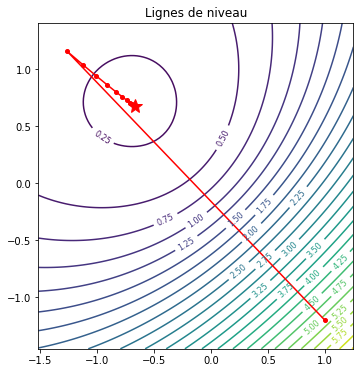

In [11]:
# Definition des grilles et evaluation de f
a_list_0 = [a_list[i][0] for i in range(len(a_list))] # on recupère les abscisses des itérés
a_list_1 = [a_list[i][1] for i in range(len(a_list))] # on recupère les ordonnées des itérés
a_0_min, a_0_max = np.min(a_list_0) - .25, np.max(a_list_0) + .25 # on définit les bornes des abscisses pour le graphe
a_1_min, a_1_max = np.min(a_list_1) - .25, np.max(a_list_1) + .25 # on définit les bornes des ordonnées pour le graphe
s = 100
a_0 = np.linspace(a_0_min, a_0_max, s) # grille abscisses
a_1 = np.linspace(a_1_min, a_1_max, s) # grille ordonnées
a_0, a_1 = np.meshgrid(a_0, a_1) # grille abcisses, grille ordonnées -> grille 2D
Z = np.zeros((s, s))
for i in range(s):
    for j in range(s):
        Z[i, j] = F([a_0[i, j], a_1[i, j]]) # valeurs de F sur la grille 2D

# Graphique des lignes de niveaux
fig, ax = plt.subplots(figsize = (6, 6))
CS = ax.contour(a_0, a_1, Z, 25)

plt.plot(a_list_0, a_list_1, marker = "o", ms = 4.0, color = "red")
plt.plot(a_star[0], a_star[1], marker = '*', ms = 15.0, color = "r")
ax.clabel(CS, fontsize = 8)
ax.set_title('Lignes de niveau')
ax.set_aspect('equal', adjustable = 'box')

<b>8) On considère la fonction $\mbox{f}$ suivante, où $\mbox{a_star}$ représente l'approximation de la solution renvoyée par l'algorithme.</b>

In [12]:
def sigmoid(t):
    return 2/(1 + np.exp(-2*t)) - 1

In [13]:
def f(x):
    return sigmoid(x[0]*a_star[0] + x[1]*a_star[1])

<b>Interpréter la figure suivante.</b>

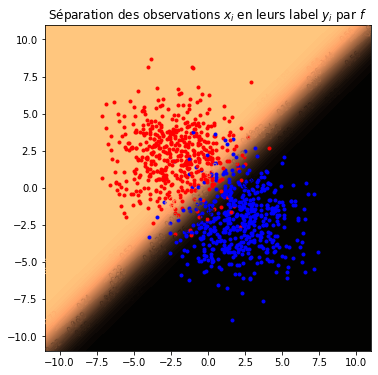

In [14]:
X0 = np.linspace(-11, 11, 100)
X1 = np.linspace(-11, 11, 100)
X0, X1 = np.meshgrid(X0, X1)
Z = f([X0, X1])

# Graphique des lignes de niveaux
fig, ax = plt.subplots(figsize = (6, 6))
CS = ax.contourf(X0, X1, Z, 50, cmap = "copper")
for i in range(M):
    if yi_list[i] == 1:
        plt.plot(xi_list[i, 0], xi_list[i, 1], linestyle = "none", marker = '.', color = "red")
    else:
        plt.plot(xi_list[i, 0], xi_list[i, 1], linestyle = "none", marker = '.', color = "blue")
ax.clabel(CS, fontsize = 8)
ax.set_title(r"Séparation des observations $x_i$ en leurs label $y_i$ par $f$")
ax.set_aspect("equal", adjustable = "box") # pour que les axes aient la même échelle

La fonction $\mbox{sigmoid}$ représente la fonction sigmoïde, https://fr.wikipedia.org/wiki/Sigmoïde_(mathématiques), (ici modifiée pour que $\mbox{sigmoid}(0) = 0$ et $\mbox{sigmoid}(+\infty) = 1$ et $\mbox{sigmoid}(-\infty) = -1$) et assure que pour des grandes valeurs de $t$, elle retourne $1$ et des grandes valeurs (négatives) $-1$. L'interpolation entre ces deux valeurs se faisant de manière progressive dans un voisinage de $0$.

Les valeurs nulles de la fonction $x\mapsto \langle x, \mbox{a_star} \rangle$ sont par définition les $x\in\mathbb{R}^2$ appartenant à la droite passant par $(0,0)$ de normale $\mbox{a_star}$. C'est la droite trouvée séparant de manière optimale, pour le critère définie par $F$, les points $x_i$ en fonction de leurs classes $\pm 1$. Quand $\langle x, \mbox{a_star}\rangle$ est grand (on est donc en particulier éloigné de la droite effectuant la séparation des points), alors on prédit (par construction du modèle et de $F$) que $x$ a pour classe $+1$. Quand $\langle x, \mbox{a_star}\rangle$ est grand "négatif", alors on prédit que $x$ a pour classe $-1$. Appliquer $\mbox{sigmoid}$ à $\langle x, \mbox{a_star}\rangle$, donnant ainsi $f(x)$, permet donc d'obtenir ces prédictions avec une transition progressive lorsque $\langle x, \mbox{a_star}\rangle$ est proche de $0$, c'est-à-dire lorsque $x$ est proche de la droite séparant les points, dit autrement encore lorsque l'on est pas sûr (vue la distribution des $x_i$ et vu le modèle) de la classe du point $x$.

Ainsi si $x$ est tel que $f(x)$ est très proche de $1$ alors, vu le modèle et les données, on a une bonne confiance que $x$ a pour classe $+1$. Si $f(x) = -0.1$, par exemple, alors le modèle penche plutôt pour la classe $-1$, mais pas avec une grande confiance.

In [15]:
def test_prediction():
    k = 0
    N = 100000
    for i in range(N):
        x, y = genererCouple()
        if abs(f(x) - y) <= 0.2: # on estime que notre modèle ne se trombe pas tant que f(x) est proche 
            # à moins de 0.2 (seuil abitraire) de y.
            # Si la condition est satisfaite, on itère le compteur des succès.
            k +=1
    return k/N

print('Le taux de succès de la prédiction de la classe est environ de : ', np.round(100*test_prediction(), 1), '%')

Le taux de succès de la prédiction de la classe est environ de :  82.1 %


<h3>II) Application au débruitage d'images</h3>

In [16]:
def ps(x, y):
    # produit scalaire entre x et y, qui peuvent être des vecteurs ou des matrices.
    return np.sum(x*y)

<b>0) Modifier la fonction codant l'algorithme de descente de gradient par rebroussement de sorte que le critère d'arrêt fasse intervenir la quantité $\frac{\| \nabla F(x)\|}{F(x)}$ plutôt que $\| \nabla F(x)\|$. Pourquoi ce changement est-il pertinent ?</b>

Ce changement permet de rendre la condition d'arrêt sur le gradient relative aux valeurs prises par $F$.

In [17]:
# Les fonctions codant l'algorithme de descente de gradient par rebroussement sont modifiées également afin de
# permettre un suivi plus détaillé des différentes valeurs d'intérêts.

class status:
    # classe qui va être utiliser pour stocker les itérées xk, les valeurs f(xk), et les normes des gradients 
    # \nabla f(xk) pendant l'éxécution de l'algorithme.
    def __init__(self):
        self.reset()
    def reset(self):
        self.x = []
        self.fx = []
        self.norm_gx = []
    def add(self, x, fx, norm_gx):
        self.x.append(x)
        self.fx.append(fx)
        self.norm_gx.append(norm_gx)

In [18]:
def rebroussement_armijo(f, x, fx, d, gxd, alpha, beta, verbose = False):
    # renvoie le pas de descente via la méthode du rebroussement d'Armijo
    t = 1
    n = 0
    fxtd = f(x + t*d)
    while fxtd >= fx + alpha*t*gxd: # l'étude du pseudo-code de la fonction montre qu'il n'y a besoin d'effectuer
        # qu'une seule évaluation de la fonction objectif f
        t = beta*t
        fxtd = f(x + t*d)
        n += 1

    if verbose:
        # on affiche (si verbose = True) le statut après le calcul du pas de descente par la méthode
        print("Nombre iter armijo : ", n)
        print("f(x) = ", fx)
        print("f(x + t*d) = ", fxtd)
        print("Pas = ", t)
    return t

In [19]:
def descente_gradient_par_rebroussement(x0, f, gradf, f_gradf, alpha, beta, epsilon, niter, verbose = False):
    # Renvoie le dernier itéré et une variable de type status qui contient les xk, f(xk), ||gradf(xk)||
    # Par rapport à la précédente implémentation, on ajoute également l'argument f_gradf qui 
    # permet le calcul dans une même fonction des valeurs f(x) et gradf(x). Cela peut-être judicieux d'un point 
    # de vue complexité algorithmique car parfois certaines quantités communes sont calculées à la fois pour f(x) 
    # et gradf(x).
    
    x = x0
    fx, gx = f_gradf(x) # on calcule les valeurs de f(x0) et gradf(x0) à l'aide de la fonction f_gradf
    
    verbose_armijo = False # par défaut on n'affiche pas ce qui se passe dans rebroussement_armijo
    
    state = status() # on inialise la variable qui va contenir les xk, f(xk), ||gradf(xk)||
    state.add(x, fx, np.linalg.norm(gx)) # on ajoute à cette variable x0, f(x0), ||gradf(x0)||
    
    n = 0
    while state.norm_gx[-1]/abs(state.fx[-1]) > epsilon and n < niter: # condition d'arrêt    
        if verbose:
            if n%200 == 0: # on affiche l'état de l'algorithme que tous les 200 itérations
                verbose_armijo = True # on affiche ce qui se passe dans rebroussement_armijo
                print("Iteration : ", n)
                print("f(x) = ", state.fx[-1])
                print("norm(g(x))/f(x) = ", state.norm_gx[-1]/state.fx[-1])
        
        t = rebroussement_armijo(f, x, fx, -gx, ps(gx, -gx), alpha, beta, verbose_armijo) # calcul du pas de descente par rebroussement
        
        x = x - t*gx # nouvel itéré
        fx, gx = f_gradf(x) # on calcule les nouvelles valeurs de fx et gradf(x) à l'aide de la fonction f_gradf
        
        state.add(x, fx, np.linalg.norm(gx))
        
        if verbose:
            if n%200 == 0:
                verbose_armijo = False
                print("")
            
        n += 1
    
    return x, state

Récupérer l'image à l'adresse : https://qdenoyelle.github.io/M1_Optim/TP/paysage.jpg et la placer dans le dossier où le TP se situe.

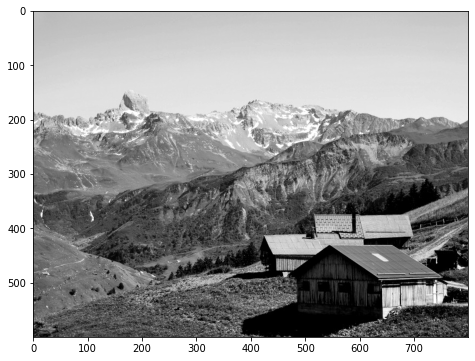

In [20]:
plt.figure(figsize = (8, 6))
img_original = plt.imread("paysage.jpg").astype(float) # chargement de l'image
img_original = sum([img_original[:, :, i] for i in range(2)]) # on transforme l'image en noir et blanc
img_original = 1/(np.max(img_original)-np.min(img_original))*(img_original - np.min(img_original))
plt.imshow(img_original, cmap = 'gray') # affichage de l'image
plt.show()

On va traiter l'image comme une matrice dont les coefficients sont le niveau de gris des pixels.

In [21]:
n, m = img_original.shape # on récupère le nombre de ligne et de colonnes.
print("Nombre de lignes : ", n)
print("Nombre de colonnes : ", m)

Nombre de lignes :  600
Nombre de colonnes :  800


On va maintenant dégrader l'image par un bruit additif gaussien (en pratique on aurait uniquement accès à l'image bruitée, ici on cré "artificiellement" le bruit).

In [22]:
bruit = .2 * np.random.randn(n, m) # bruit gaussien qui va être appliqué sur l'image
img_bruit = img_original + bruit # on bruite additivement l'image

<b>1) Afficher l'image bruitée.</b>

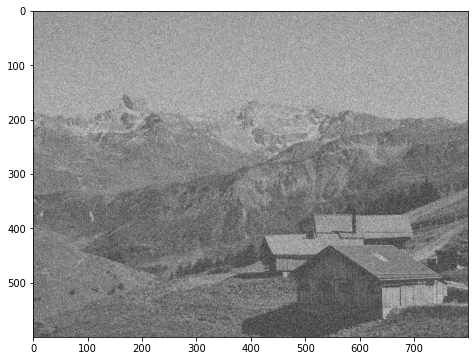

In [23]:
plt.figure(figsize = (8, 6))
plt.imshow(img_bruit, cmap = "gray") # affichage de l'image
plt.show()

Dans la suite les images seront vues comme des tableaux de valeurs (chaque pixel est un nombre représentant le niveau de gris), c'est à dire des matrices à $n$ lignes et $m$ colonnes.

On va maintenant chercher à débruiter l'image ci-dessus (i.e. diminuer l'impact du bruit). La méthode adoptée va consister à résoudre le problème d'optimisation suivant
$$
\min_{x\in\mathcal{M}_{n,m}(\mathbb{R})} F(x),
$$
où
$$
F(x) = \frac12 \sum_{i=1}^n\sum_{j=1}^m (x_{i,j} - y_{i,j})^2 + \lambda \sum_{i=1}^{n-1}\sum_{j=1}^m N_\varepsilon(x_{i+1,j} - x_{i,j}) + \lambda \sum_{i=1}^{n}\sum_{j=1}^{m-1} N_\varepsilon(x_{i,j+1} - x_{i,j}).
$$
$y\in\mathcal{M}_{n,m}(\mathbb{R})$ est l'image bruitée (la donnée du problème), $\lambda>0$ une constante et 
$$
\forall t\in\mathbb R, \quad N_\varepsilon(t) = \sqrt{t^2+\varepsilon},
$$
avec $\varepsilon>0$.

In [24]:
y = img_bruit # on stocke dans y l'image bruitée 

<b>3) Interpréter $F$.</b>

$F$ est composé de trois termes. Le premier, qui se réécrit $\frac12 \|x - y\|^2$ où $\|\cdot\|$ représente la distance euclidienne sur l'espace des matrices considéré ici (issue du produit scalaire canonique $\langle A,B\rangle = \mbox{Tr}(AB^T)$), représente un terme d'attache aux données : il mesure l'erreur quadratique au carrée entre une estimation $x$ et la donnée du problème $y$ (l'image bruitée). Les deux autres termes mesurent la variation de $x$ entre deux pixels successifs respectivement verticalement et horizontalement. En minimisant cette fonction objective, on va ainsi obtenir un $x$ ($F$ admet un unique minimum global, cf ci-dessous) qui est proche de la donnée du problème tout en lissant les variations locales : on atténue ainsi l'impact du bruit. Le compromis entre être proche des données et l'atténuation du bruit est controlé par le paramètre $\lambda$ (plus $\lambda$ est grand plus l'image sera lissée car les deux derniers termes deviennent plus pénalisant s'ils sont grands).

<b>4) Justifier que $F$ est $\mathcal C^\infty$ sur $\mathcal{M}_{n,m}(\mathbb{R})$. Montrer que $F$ est strictement convexe et admet un unique minimum global sur $\mathcal{M}_{n,m}(\mathbb{R})$.</b>

Le premier terme composant $F$ est polynomiale en les coefficients de $x\in\mathcal{M}_{n,m}(\mathbb{R})$. Ensuite $N_\varepsilon$ est $\mathcal{C}^{\infty}$ sur $\mathbb{R}$. Donc par sommes et composés de fonctions $\mathcal{C}^{\infty}$, $F$ est $\mathcal C^\infty$ sur $\mathcal{M}_{n,m}(\mathbb{R})$.

La fonction $f:x\in\mathcal{M}_{n,m}(\mathbb{R})\mapsto \frac12 \|x - y\|^2$ est strictement convexe car sa matrice hessienne est la matrice $I_{(nm)^2}$ qui est définie positive. Attention ici à la dimension de la matrice hessienne : l'espace de départ de $f$ est de dimension $nm$, donc la matrice hessienne de $f$ a $(nm)^2$ coefficients.

Ensuite, on vérifie aisément que $N_\varepsilon$ est convexe sur $\mathbb{R}$ (il suffit par exemple de calculer sa dérivée seconde et vérifier qu'elle est positive sur $\mathbb{R}$). Donc pour tous $i, j$, $x\in\mathcal{M}_{n,m}(\mathbb{R})\mapsto N_\varepsilon(x_{i+1,j} - x_{i,j})$ et $x\in\mathcal{M}_{n,m}(\mathbb{R})\mapsto N_\varepsilon(x_{i,j+1} - x_{i,j})$ sont convexes car ce sont des composés entre des fonctions convexes et des fonctions linéaires. Attention la composée de deux fonctions convexes n'est pas convexe en général par contre convexe avec linéaire oui (le redémontrer en exercice). Donc comme la somme de fonctions convexes est convexe, on a bien
$$
    R:x\in\mathcal{M}_{n,m}(\mathbb{R})\mapsto \sum_{i=1}^{n-1}\sum_{j=1}^m N_\varepsilon(x_{i+1,j} - x_{i,j}) + \sum_{i=1}^{n}\sum_{j=1}^{m-1} N_\varepsilon(x_{i,j+1} - x_{i,j}),
$$
est convexe.

Enfin $f$ est strictement convexe, $R$ est convexe donc $F = f + \lambda R$ est strictement convexe sur $\mathcal{M}_{n,m}(\mathbb{R})$.

Comme $F$ est strictement convexe, $F$ admet au plus un minimum global sur $\mathcal{M}_{n,m}(\mathbb{R})$. Montrons que $F$ est coercive sur $\mathcal{M}_{n,m}(\mathbb{R})$. La fonction $f$ l'est car pour tout $x$, $f(x)\geq \frac12(\|x\|_2 - \|y\|_2)^2$ par inégalité triangulaire inverse et donc dès que $(x_n)_{n\in\mathbb N}$ est une suite de matrices qui tend en norme vers $+\infty$, on obtient bien que $f(x_n)\to +\infty$, ce qui valide bien l'affirmation par critère séquentiel de la coercivité. Puis comme $N_\varepsilon \geq 0$, on a $F\geq f$, d'où $F$ est bien coercive sur $\mathcal{M}_{n,m}(\mathbb{R})$. Elle est aussi continue, donc elle admet un minimum global sur $\mathcal{M}_{n,m}(\mathbb{R})$, qui est par conséquent unique.

<b>5) Calculer le gradient de $F$. On pourra introduire les matrices $L\in\mathcal{M}_{n-1, n}(\mathbb{R})$ avec des $-1$ sur la diagonale, et des $1$ sur la sur-diagonale, et $C\in\mathcal{M}_{m, m-1}(\mathbb{R})$ la matrice avec des $-1$ sur la diagonale, $1$ sur la sous-diagonale</b>.

Soit $x\in\mathcal{M}_{n,m}(\mathbb{R})$, on a $\nabla F(x) = \nabla f(x) + \lambda\nabla R(x)$ en reprenant les notations introduites à la question précédente pour $f$ et $R$. Or $\nabla f(x) = x - y$. On a pour tout $h\in\mathcal{M}_{n,m}(\mathbb R)$ 
\begin{align}
    R(x + h) &= R(x) + \sum_{i=1}^{n-1}\sum_{j=1}^m N_\varepsilon'(x_{i+1,j} - x_{i,j})(h_{i+1,j} - h_{i,j}) + \sum_{i=1}^{n}\sum_{j=1}^{m-1} N_\varepsilon'(x_{i,j+1} - x_{i,j})(h_{i,j+1} - h_{i,j}) + o(\|h\|).\\
\end{align}
On reconnaît que $\sum_{i=1}^{n-1}\sum_{j=1}^m N_\varepsilon'(x_{i+1,j} - x_{i,j})(h_{i+1,j} - h_{i,j})$ est un produit scalaire entre la matrice de taille $n-1 \times m$ et de coefficient $(i,j)$ : $N_\varepsilon'(x_{i+1,j} - x_{i,j})$ et la matrice de taille $n-1 \times m$ et de coefficient $(i,j)$ : $h_{i+1,j} - h_{i,j}$. Cette dernière matrice s'écrit $Lh$ où $L\in\mathcal{M}_{n-1,m}(\mathbb{R})$ est définie avec des $-1$ pour les coefficients $(i,i)$ et $1$ pour les coefficients $(i,i+1)$. En posant la fonction $N_{\varepsilon,(n-1,m)}':\mathcal{M}_{n-1,m}(\mathbb{R})\to \mathcal{M}_{n-1,m}(\mathbb{R})$ définie par
$$
    \forall y\in\mathcal{M}_{n-1,m}(\mathbb{R}), \quad N_{\varepsilon,(n-1,m)}'(y) = \left(N_\varepsilon'(y_{i,j})\right)_{1\leq i\leq n-1 ; \, 1\leq j\leq m},
$$
qui revient à appliquer la fonction $N_\varepsilon':\mathbb R\to\mathbb R$ à tous les coefficients de la matrice $y$, on déduit alors que
$$
    \sum_{i=1}^{n-1}\sum_{j=1}^m N_\varepsilon'(x_{i+1,j} - x_{i,j})(h_{i+1,j} - h_{i,j}) = \langle N_{\varepsilon,(n-1,m)}'(Lx), Lh\rangle = \langle L^T N_{\varepsilon,(n-1,m)}'(Lx), h\rangle.
$$
Similairement, en posant $C\in\mathcal{M}_{m,m-1}(\mathbb{R})$ la matrice avec des $-1$ pour les coefficients $(i,i)$ et $1$ pour les $(i+1,i)$, et $N_{\varepsilon,(n,m-1)}'$ définie comme $N_{\varepsilon,(n-1,m)}'$ mais cette fois pour des $y\in\mathcal{M}_{n-1,m}(\mathbb{R})$, on remarque que 
$$
    \sum_{i=1}^{n}\sum_{j=1}^{m-1} N_\varepsilon'(x_{i,j+1} - x_{i,j})(h_{i,j+1} - h_{i,j}) = \langle N_{\varepsilon,(n,m-1)}'(xC), hC\rangle = \langle N_{\varepsilon,(n,m-1)}'(xC)C^T, h\rangle,
$$
où pour la dernière égalité on a utilisé : $\langle N_{\varepsilon,(n,m-1)}'(xC), hC\rangle = \mbox{Tr}(N_{\varepsilon,(n,m-1)}'(xC)^T(hC)) = \mbox{Tr}(N_{\varepsilon,(n,m-1)}'(xC)\, (hC)^T) = \mbox{Tr}(N_{\varepsilon,(n,m-1)}'(xC)C^Th)$.

Ainsi $ R(x + h) = R(x) + \langle L^T N_{\varepsilon,(n-1,m)}'(Lx) + N_{\varepsilon,(n,m-1)}'(xC)C^T, h\rangle + o(\|h\|)$ et donc
\begin{align}
    \nabla R(x) = L^T N_{\varepsilon,(n-1,m)}'(Lx) + N_{\varepsilon,(n,m-1)}'(xC)C^T.
\end{align}
On peut faire une analyse dimensionnelle pour vérifier que tout est cohérent. $\nabla R(x)$ est censé être une matrice de taille $n\times m$ ($R$ est une application de l'espace vectoriel $\mathcal M_{n,m}(\mathbb R)$ à valeurs dans $\mathbb R$, donc sa différentielle est une forme linéaire sur $\mathcal M_{n,m}(\mathbb R)$, et donc le gradient de $R$ existe et est un élément de l'espace vectoriel $\mathcal M_{n,m}(\mathbb R)$). Or $N_{\varepsilon,(n-1,m)}'(Lx)$ est de taillme $n-1\times m$ et $L^T$ de taille $n\times n-1$, donc c'est bon pour le premier terme. $N_{\varepsilon,(n,m-1)}'(xC)$ est de taille $n\times m-1$ (car $xC$ est une matrice de taille $n\times m-1$) et $C^T$ est de taille $m-1\times m$, donc c'est bon aussi pour le second.

Et donc
\begin{align}
    \nabla F(x) = x - y + \lambda L^T N_{\varepsilon,(n-1,m)}'(Lx) + \lambda N_{\varepsilon,(n,m-1)}'(xC)C^T.
\end{align}

<b>L'avantage de cette expression pour le gradient de $R$ est qu'elle est "vectorielle" : il n'y a pas de sommes, mais uniquement des produits matriciels et l'application de fonctions coefficient par coefficient (pour $N_{\varepsilon,(n,m-1)}'(xC)$ et $N_{\varepsilon,(n-1,m)}'(Lx)$). L'implémentation va donc être rapide en Python, car on va éviter les boucles for. Un autre calcul aurait pu être fait pour trouver ce gradient, mais elle aurait fait intervenir des sommes. Obtenir par la suite l'expression "vectorialisée" est néanmois moins visible sous cette forme. Je mets tout de même le calcul qui est tout à fait admissible et adapté pour une utilisation à des fins purement mathématiques.</b>

En remarquant que pour tout $i\in\{1,\ldots,n-1\}$, $j\in\{1,\ldots,m\}$, $N_\varepsilon(x_{i+1,j} - x_{i,j}) = N_\varepsilon(\langle \ell_{i,j}, x\rangle)$, avec $\ell_{i,j} = E_{i+1,j} - E_{i,j}$ et $E_{k,l}\in\mathcal{M}_{n,m}(\mathbb{R})$ la matrice avec $1$ en $(k,l)$ et $0$ partout sinon (les $E_{k,l}$ forment la base canonique de $\mathcal{M}_{n,m}(\mathbb{R})$). Puis pour tout $i\in\{1,\ldots,n\}$, $j\in\{1,\ldots,m-1\}$, $N_\varepsilon(x_{i,j+1} - x_{i,j}) = N_\varepsilon(\langle c_{i,j}, x\rangle)$, avec $c_{i,j} = E_{i,j+1} - E_{i,j}$. Ainsi on a 
$$
    \nabla R(x) = \sum_{i=1}^{n-1}\sum_{j=1}^m N_\varepsilon'(x_{i+1,j} - x_{i,j})\ell_{i,j}^T + \sum_{i=1}^{n}\sum_{j=1}^{m-1} N_\varepsilon'(x_{i,j+1} - x_{i,j})c_{i,j}^T.
$$

<b>6) Implémenter les matrices $L$ et $C$. Implémenter des fonctions $\mbox{L_mult}$ et $\mbox{Lt_mult}$ qui réalisent respectivement l'opération $Lx$ pour $x\in\mathcal{M}_{n, m}(\mathbb{R})$ et $L^Tv$ pour $v\in\mathcal{M}_{n-1, m}(\mathbb{R})$. Puis implémenter des fonctions $\mbox{C_mult}$ et $\mbox{Ct_mult}$ qui réalisent respectivement l'opération $xC$ pour $x\in\mathcal{M}_{n, m}(\mathbb{R})$ et $vC^T$ pour $v\in\mathcal{M}_{n, m-1}(\mathbb{R})$.</b>

In [25]:
L = np.zeros([n - 1, n])
for i in range(n - 1):
    for j in range(n):
        if i == j:
            L[i, j] = -1
        if j == i + 1:
            L[i, j] = 1

C = np.zeros([m, m - 1])
for i in range(m):
    for j in range(m - 1):
        if i == j:
            C[i, j] = -1
        if i == j + 1:
            C[i, j] = 1

In [26]:
# En première lecture de cette question, vous pouvez vous concentrer sur les implémentations des fonctions données
# dans les "else".
#
# Elles correspondent à des implémentations "naïves" et directes des opérations demandées.
# Nous verrons plus tard qu'il est possible de réécrire ces opérations de manière plus efficace.
#
# Le booléen "implementation_efficace", que l'on fixera comme vrai ou faux à la demande, permettra
# de switcher entre l'une ou l'autre des implémentations pour tester la différence de vitesse d'éxécution.

def L_mult(x):
    if implementation_efficace:
        return x[1:n, :] - x[0:n-1, :]
    else:
        return np.dot(L, x)
def Lt_mult(v):
    if implementation_efficace:
        u = np.zeros([n , m])
        u[0, :] = -v[0, :]
        u[1:n-1, :] = v[0:n-2, :] - v[1:n-1, :]
        u[n-1, :] = v[n-2, :]
        return u
    else:
        return np.dot(L.transpose(), v)

def C_mult(x):
    if implementation_efficace:
        return x[:, 1:m] - x[:, 0:m-1]
    else:
        return np.dot(x, C)
def Ct_mult(v):
    if implementation_efficace:
        u = np.zeros([n , m])
        u[:, 0] = -v[:, 0]
        u[:, 1:m-1] = v[:, 0:m-2] - v[:, 1:m-1]
        u[:, m-1] = v[:, m-2]
        return u
    else:
        return np.dot(v, C.transpose())

<b>7) Ecrire une fonction $\mbox{F}$ qui renvoient pour une matrice $x\in\mathcal{M}_{n, m}(\mathbb{R})$, la valeur $F(x)$ de la fonction objective du problème d'optimisation considéré. On pourra au préalable implémenter des fonctions $\mbox{N_eps}$ et $\mbox{dN_eps}$ représentant respectivement $N_\varepsilon$ et $N_\varepsilon'$. On prendra $\varepsilon = 10^{-5}$.</b>

In [27]:
epsilon = 1e-5
def N_eps(t):
    return np.sqrt(t**2 + epsilon)
def dN_eps(t):
    return t/N_eps(t)
def R(x):
    return np.sum(N_eps(L_mult(x))) + np.sum(N_eps(C_mult(x)))

In [28]:
def F(x):
    return .5*ps(x - y, x - y) + lbda*R(x)

<b>8) Ecrire la fonction $\mbox{gradF}$ implémentant $\nabla F$.</b>

Pour rappel on a noté : $F = f + \lambda R$.

Vu l'expression du gradient de $R$ :
\begin{align}
    \nabla R(x) = L^T N_{\varepsilon,(n-1,m)}'(Lx) + N_{\varepsilon,(n,m-1)}'(xC)C^T,
\end{align}
et les fonctions $\mbox{L_mult}$, $\mbox{Lt_mult}$, $\mbox{C_mult}$, $\mbox{Ct_mult}$ définies précédemment, on obtient directement la fonction $\mbox{gradR}$ ci-dessous.

In [29]:
def gradR(x):
    return Lt_mult(dN_eps(L_mult(x))) + Ct_mult(dN_eps(C_mult(x)))

def gradF(x):
    return x - y + lbda*gradR(x)

On remarque que dans l'implémentation de $F(x)$, on a besoin de calculer une fois $\mbox{L_mult}(x)$ et une fois $\mbox{C_mult}(x)$. On a également besoin de calculer ces quantités dans $\mbox{gradF}(x)$. Donc en rassemblant dans une même fonction le calcul de $F(x)$ et $\mbox{gradF}(x)$, on va économiser deux produits matriciels, ce qui est toujours bon à prendre !

Ceci était évidemment non attendu pour répondre aux questions du TP.

In [30]:
def F_gradF(x):
    # on stocke les quantités réutilisées plusieurs fois dans des variables
    diff = x - y
    Lx = L_mult(x)
    xC = C_mult(x)
    #
    
    f = .5*ps(diff, diff) + lbda*np.sum(N_eps(Lx)) + lbda*np.sum(N_eps(xC)) # F(x)
    g = diff + lbda*Lt_mult(dN_eps(Lx)) + lbda*Ct_mult(dN_eps(xC)) # gradF(x)
    
    return f, g

In [31]:
implementation_efficace = True
lbda = 1.0
x = np.random.randn(n, m)

print("Comparaison des temps de calcul de F(x) et gradF(x) séparemment ou ensemble.")
t = time()
for i in range(100):
    F(x)
    gradF(x)
dt = time() - t
print("Implémentation en deux fois : ", dt)

t = time()
for i in range(100):
    F_gradF(x)
dt = time() - t
print("Implémentation en une fois : ", dt)

Comparaison des temps de calcul de F(x) et gradF(x) séparemment ou ensemble.
Implémentation en deux fois :  2.69496488571167
Implémentation en une fois :  1.6891629695892334


<b>Vérifier votre implémentation du gradient via le calcul de taux d'accroissement de $\mbox{F}$.</b>

In [32]:
eta = 1e-5
i, j = np.random.randint(n), np.random.randint(m) # on choisit des indices au hasard pour la dérivée partielle
E = np.zeros([n, m])
E[i, j] = 1 # E_{i, j} vecteur de la base canonique de M_{n,m}(R)
x = np.random.randn(n, m) # point auquel on calcule la dérivée partielle
print("Approx. par différence finie centrée de \partial_{i, j}F(x) :", (F(x + eta*E) - F(x - eta*E))/(2*eta))
print("Approx. par différence finie centrée de \partial_{i, j}F(x) :", gradF(x)[i, j])
print("Erreur relative : ", np.abs(((F(x + eta*E) - F(x - eta*E))/(2*eta) - gradF(x)[i, j])/(gradF(x)[i, j])))

Approx. par différence finie centrée de \partial_{i, j}F(x) : -4.1377730667591095
Approx. par différence finie centrée de \partial_{i, j}F(x) : -4.137759734223584
Erreur relative :  3.2221628083198913e-06


<b>9) Utiliser l'algorithme de descente de gradient par rebroussement d'Armijo pour le résoudre le problème d'optimisation. On prendra pour l'instant $\lambda = 0.2$.</b>

In [33]:
lbda = .2
alpha, beta = 1e-4, .2 # valeurs de alpha et beta qui donne une convergence relativement rapide de l'algorithme.
# Faites vos tests !

implementation_efficace = True
verbose = True
max_iter = 2000
tol = 1e-6

t_start = time()
x, state = descente_gradient_par_rebroussement(y, F, gradF, F_gradF, alpha, beta, tol, max_iter, verbose)
t_end = time()

print("--- FIN ---")
print("time = ", t_end - t_start)
print("F(x) = ", state.fx[-1])
print("norm(gradF(x))/norm(F(x)) = ", state.norm_gx[-1]/state.fx[-1])
print("niter = ", len(state.x) - 1)

Iteration :  0
f(x) =  45270.0772043346
norm(g(x))/f(x) =  0.008534976159191998
Nombre iter armijo :  1
f(x) =  45270.0772043346
f(x + t*d) =  27781.63821092641
Pas =  0.2

Iteration :  200
f(x) =  12044.515901095478
norm(g(x))/f(x) =  0.0004713755917895655
Nombre iter armijo :  3
f(x) =  12044.515901095478
f(x + t*d) =  12044.392208904128
Pas =  0.008000000000000002

Iteration :  400
f(x) =  12038.42009837839
norm(g(x))/f(x) =  0.00023758674852554707
Nombre iter armijo :  4
f(x) =  12038.42009837839
f(x + t*d) =  12038.410643731395
Pas =  0.0016000000000000005

Iteration :  600
f(x) =  12037.93077477024
norm(g(x))/f(x) =  4.967713823329404e-05
Nombre iter armijo :  4
f(x) =  12037.93077477024
f(x + t*d) =  12037.93032656296
Pas =  0.0016000000000000005

Iteration :  800
f(x) =  12037.88075748199
norm(g(x))/f(x) =  1.2291731047393183e-05
Nombre iter armijo :  3
f(x) =  12037.88075748199
f(x + t*d) =  12037.880697925862
Pas =  0.008000000000000002

Iteration :  1000
f(x) =  12037.875235

<b>10) Illustrer la convergence de l'algorithme.</b>

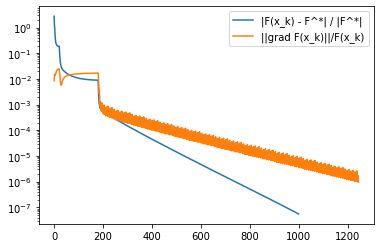

In [41]:
plt.semilogy([abs(state.fx[i] - state.fx[-1])/state.fx[-1] for i in range(1000)], label = "|F(x_k) - F^*| / |F^*|")
plt.semilogy([state.norm_gx[i]/state.fx[i] for i in range(len(state.x))], label = "||grad F(x_k)||/F(x_k)")
plt.legend()
plt.show()

<b>11) Afficher l'image reconstruite et la comparée aux autres images. Commenter.</b>

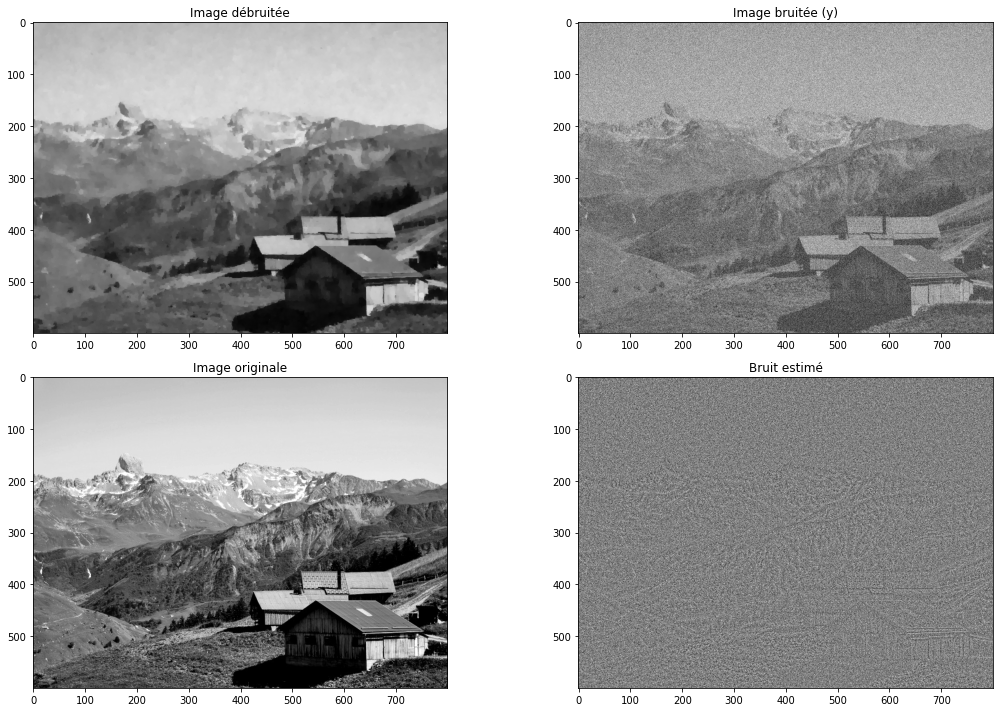

In [35]:
plt.figure(figsize = (16, 10))
#
plt.subplot(2, 2, 1)
plt.imshow(x, cmap = 'gray')
plt.title('Image débruitée')
#
plt.subplot(2, 2, 2)
plt.imshow(img_bruit, cmap = 'gray')
plt.title('Image bruitée (y)')
#
plt.subplot(2, 2, 3)
plt.imshow(img_original, cmap = 'gray')
plt.title('Image originale')
#
plt.subplot(2, 2, 4)
plt.imshow(img_bruit - x, cmap = 'gray')
plt.title('Bruit estimé')
plt.tight_layout()
plt.show()

On remarque l'effet cartoon produite par la méthode de reconstruction : on a des zones uniformes en niveau de gris. C'est à cause du fait que $N_{\varepsilon}$ approxime la valeur absolue quand $\varepsilon$ est petit. Ainsi on minimise (en plus du terme d'attache aux données), la norme $\ell_1$ du gradient de l'image. Or l'utilisation de la norme $\ell_1$ dans un problème d'optimisation a tendance à produire des vecteurs solutions avec beaucoup de $0$ (solutions dites parcimonieuses).  Ici l'image solution du problème va donc avoir un gradient avec beaucoup de $0$, c'est-à-dire une image de type constante par zones !

<b>12) Réaliser une implémentation de plus faible complexité des fonctions $\mbox{L_mult}$ et $\mbox{C_mult}$. Constater le gain en pratique.</b>

Déjà fait dans le code, voir ci-dessus. La variable booléenne $\mbox{implementation_efficace}$ permet de choisir entre l'implémentation rapide ou non.

Dans l'implémentation naïve de $Lx$, faite dans la fonction $\mbox{L_mult}$, on utilise la matrice $L$ qui ne contient quasiment que des $0$ et on réalise le produit matriciel. C'est peu efficace. Alors que si on analyse l'effet de la multiplication à gauche de $x$ par $L$, on remarque que cela revient à faire des différences successives entre les lignes de $x$ : $\mbox{x[1:n, :] - x[0:n-1, :]}$. La complexité de $\mbox{np.dot(L, x)}$ est $O(n^2m)$, alors que $\mbox{x[1:n, :] - x[0:n-1, :]}$ est $O(nm)$.

Pour $xC$, cette fois ce sont des opérations sur les colonnes qui sont effectuées (car multiplication de $x$ à droite par $C$). Le raisonnement est le même.

On peut de même améliorer l'implémentation de $\mbox{Lt_mult}$ et $\mbox{Ct_mult}$. Il faut de nouveau analyser respectivement l'effet de multiplier à gauche par $L^T$ et à droite par $C^T$. C'est un peu plus compliqué. On est obligé d'utiliser une variable temporaire de calcul et il y a plus d'opérations. Le gain est moins important, mais présent tout de même.

In [36]:
print("Comparaison des temps de calcul de L_mult(x) en fonction des deux implémentations.")
t = time()
x = np.random.randn(n, m)
implementation_efficace = False
for i in range(1000):
    L_mult(x)
dt = time() - t
print("Implémentation via np.dot(L, x) : ", dt)

implementation_efficace = True
t = time()
for i in range(1000):
    L_mult(x)
dt = time() - t
print("Implémentation par opérations sur les lignes de x : ", dt)

Comparaison des temps de calcul de L_mult(x) en fonction des deux implémentations.
Implémentation via np.dot(L, x) :  4.062842130661011
Implémentation par opérations sur les lignes de x :  0.25103187561035156


In [37]:
print("Comparaison des temps de calcul de Lt_mult(v) en fonction des deux implémentations.")
v = np.random.randn(n - 1, m)
implementation_efficace = False
t = time()
for i in range(1000):
    Lt_mult(v)
dt = time() - t
print("Implémentation via np.dot(L.transpose(), v) : ", dt)

implementation_efficace = True
t = time()
for i in range(1000):
    Lt_mult(v)
dt = time() - t
print("Implémentation par opérations sur les lignes de v : ", dt)

Comparaison des temps de calcul de Lt_mult(v) en fonction des deux implémentations.
Implémentation via np.dot(L.transpose(), v) :  3.987359046936035
Implémentation par opérations sur les lignes de v :  0.6380228996276855
